# Continuous Control

---

This notebook includes an agent to solve the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.


## Setup

To run code, you need to set up an environment and import necessary packages.

In [1]:
import copy
import math
import random
import time
from collections import deque,namedtuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import progressbar as pb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from unityagents import UnityEnvironment

%matplotlib inline

### Load and observe Reacher environment
Reacher environment is the target environment we want to solve in this note. Let's observe how the environment looks like

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Check GPU availability
Let's check which device is being used.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: ",device)

using device:  cuda:0


## Build an agent

This section builds an agent to solve the environment with DDPG.

### DDPG
You need to define an Actor model and Critic model for DDPG. Actor model is responsible for producing an action from a given state. Critic model is responsible for estimating Action-State value which is used as a target to learn Actor as well as Critic itself.

In [4]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, num_hidden1=256, num_hidden2=128):
        super(Actor, self).__init__()
        
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, num_hidden1)
        self.fc2 = nn.Linear(num_hidden1, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        return torch.tanh(self.fc2(x))


In [5]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, num_hidden1=256, num_hidden2=128):
        super(Critic, self).__init__()

        torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, num_hidden1)
        self.fc2 = nn.Linear(num_hidden1 + action_size, num_hidden2)
        self.fc3 = nn.Linear(num_hidden2, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.leaky_relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x) 


### Parameters
Parameters for learnings are combined into a class called DDPGAgentParams which has default values as follows.


|Parameter | Default Value |
| :--- | --- |
| Replay Buffer Size | 1e6 |
| Mini Batch Size | 512 |
| Actor Learning Rate | 1e-5 |
| Critic Learning Rate | 1e-4 |
| Gamma | 0.99 |
| Tau for soft updating | 1e-3 |
| Weight Decay for Critic | 0 |
| Sigma of Noise | 0.2 |
| Random Seed | 123 |


In [6]:
class DDPGAgentParams():
    def __init__(
        self, 
        buffer_size=int(1e6), 
        batch_size=512, 
        actor_lr = 1e-5, 
        critic_lr = 1e-4, 
        gamma = .99, 
        tau = 1e-3,
        critic_weight_decay=0,
        noise_sigma=0.2,
        seed=123):
        
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.gamma = gamma
        self.tau = tau
        self.critic_weight_decay = critic_weight_decay
        self.noise_sigma = noise_sigma
        self.seed = seed


In [7]:
class DDPGAgent():
    def __init__(self, state_size, action_size, params, device="cpu"):
        self.params = params
        self.device = device
        self.seed = random.seed(params.seed)
        
        self.actor_local = Actor(state_size, action_size, params.seed).to(device)
        self.actor_target = Actor(state_size, action_size, params.seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=params.actor_lr)

        self.critic_local = Critic(state_size, action_size, params.seed).to(device)
        self.critic_target = Critic(state_size, action_size, params.seed).to(device)
        self.critic_loss = nn.MSELoss()
        self.critic_optimizer = optim.Adam(
            self.critic_local.parameters(), 
            lr=params.critic_lr, 
            weight_decay=params.critic_weight_decay)
        
        self.memory = ReplayBuffer(params.buffer_size, params.batch_size, params.seed)
        self.n_step = 0

    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.n_step += 1
        if len(self.memory) > self.params.batch_size and self.n_step % 20 == 0:
            for _ in range(10):
                experiences = self.memory.sample()
                self.learn(experiences)
            

    def to_float_tensor(self, ndarray):
        return torch.from_numpy(ndarray).float().to(self.device)
    
    def to_numpy(self, tensor):
        return tensor.detach().cpu().numpy()
    
    def act(self, state, add_noise=True):
        state_tensor = self.to_float_tensor(state)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.to_numpy(self.actor_local(state_tensor))
        
        self.actor_local.train()
        
        if add_noise:
            action += np.random.normal(scale=self.params.noise_sigma)

        return np.clip(action, -1, 1)

    def reset(self):
        # We don't need to reset the noise as we simply use normal distribution.
        pass
      
    
    def learn(self, experiences):
        states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor = experiences
        gamma = self.params.gamma
        
        # Q Target (with target network)
        actions_next_tensor = self.actor_target(next_states_tensor)
        Q_targets_next = self.critic_target(next_states_tensor, actions_next_tensor)
        Q_targets = rewards_tensor + (gamma * Q_targets_next * (1 - dones_tensor))

        # Q Expected (with local network)
        Q_expected = self.critic_local(states_tensor, actions_tensor)
        critic_loss = self.critic_loss(Q_expected, Q_targets)
        
        # Optimize Critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # Actor loss
        actions_tensor = self.actor_local(states_tensor)
        actor_loss = -self.critic_local(states_tensor, actions_tensor).mean()

        # Optimize Actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update
        self.soft_update(self.critic_local, self.critic_target, self.params.tau)
        self.soft_update(self.actor_local, self.actor_target, self.params.tau)             
            
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", "state, action, reward, next_state, done")
        
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e =self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        n = min(self.batch_size, len(self.memory))
        experiences = random.sample(self.memory, k=n)
        
        states = torch.from_numpy(np.array([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences])).float().to(device)
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

## Train function

This is a train function to learn from the environment.

In [15]:

def train(episode=1000, max_t=1000):
    scores = []
    # Deque containing last 100 scores
    scores_deque = deque(maxlen=100)

    for i in range(1, episode + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        for _ in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 

        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_deque)))
    return scores


## Run the Agent

Let's run then agent and learn from the environment. The train function executes 1000 episodes. The environment is considered as solved when the agent get an average score of +30 over 100 consecutive episodes. In each episode, it execute 1000 steps.

In [10]:
params = DDPGAgentParams()
agent = DDPGAgent(state_size, action_size, params, device=device)

scores = []
scores = train()


Episode 100	Average Score: 2.30
Episode 200	Average Score: 10.43
Episode 300	Average Score: 16.17
Episode 400	Average Score: 20.75
Episode 500	Average Score: 23.25
Episode 600	Average Score: 27.01
Episode 700	Average Score: 31.07
Episode 800	Average Score: 30.39
Episode 900	Average Score: 31.56
Episode 1000	Average Score: 31.57


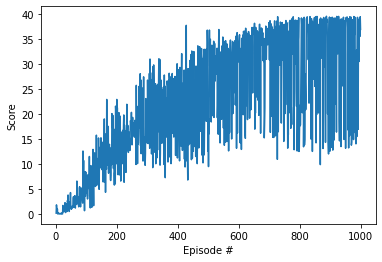

In [11]:
# Plot average scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Observe the trained agent

You can see how the trained agent works in the environment by running `show` function.

In [16]:
def show(max_t=1000):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    agent.reset()

    score = 0
    for i in range(1, max_t+1):
        action = agent.act(state, add_noise=False)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]

        state = next_state
        score += reward
        print('\rStep: {}, Score: {:.2f}'.format(i, score), end="")
        _
        if done:
            break 

    print('\rStep: {}, Score: {:.2f}'.format(i, score))



## Best agent

Here is the best agent trained so far. Load and run the best agent how it does.

In [19]:
params = DDPGAgentParams()
agent = DDPGAgent(state_size, action_size, params, device=device)

agent.actor_local.load_state_dict(torch.load('checkpoint_actor_best.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_best.pth'))

show(max_t=1000)

Step: 1000, Score: 39.58
